In [ ]:
import zipfile
import os
from pathlib import Path
import pdfplumber
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime
import re
import os
import logging
import pdfminer.settings
import os, re, logging
import pandas as pd
import pdfplumber, pdfminer.settings

# Be tolerant/quiet with sketchy PDFs
pdfminer.settings.STRICT = False
logging.getLogger("pdfminer").setLevel(logging.ERROR)

In [ ]:

RE_PARTICULARS = re.compile(r"\bparticulars\b", re.I)
RE_GDP = re.compile(r"\bgross\s+direct\s+premium\b", re.I)

HEADER_KIND_RE = re.compile(
    r"for\s+the\s+(quarter|period)\s+ended.*?(\d{1,2})(?:st|nd|rd|th)?\s+([A-Za-z]+)\s+(\d{4})",
    re.I | re.S,
)

def _norm(x):
    if not isinstance(x, str): return x
    return re.sub(r"\s+", " ", x).strip()

def table_contains(table, regex):
    for row in table or []:
        for cell in row or []:
            if isinstance(cell, str) and regex.search(_norm(cell)):
                return True
    return False

def extract_target_table_from_pdf(path):
    """Return the full NL-4 table that has both 'Particulars' and 'Gross Direct Premium'."""
    with pdfplumber.open(path) as pdf:
        for page in pdf.pages:
            text = page.extract_text() or ""
            if "FORM NL-4-PREMIUM SCHEDULE" not in text:
                continue
            for settings in (
                {"vertical_strategy": "lines", "horizontal_strategy": "lines", "snap_tolerance": 3, "join_tolerance": 3},
                {}
            ):
                try:
                    tables = page.extract_tables(table_settings=settings) if settings else page.extract_tables()
                except Exception:
                    continue
                for table in tables or []:
                    if table_contains(table, RE_PARTICULARS) and table_contains(table, RE_GDP):
                        norm = [[_norm(c) for c in (row or [])] for row in (table or [])]
                        return norm
    return None

def pick_header_and_gdp(table):
    """Return a 1-row DataFrame (header row as columns) keeping only the GDP row."""
    if not table: 
        return None
    width = max(len(r) for r in table)
    rows = [ (r + [None]*(width - len(r))) for r in table ]

    header_idx = next((i for i, r in enumerate(rows)
                       if any(isinstance(c, str) and RE_PARTICULARS.search(c or "") for c in r)), None)
    if header_idx is None:
        return None

    gdp_idx = next((i for i, r in enumerate(rows)
                    if any(isinstance(c, str) and RE_GDP.search(c or "") for c in r)), None)
    if gdp_idx is None:
        return None

    header = [c if (isinstance(c, str) and c.strip()) else None for c in rows[header_idx]]
    if not any(header):
        header = [f"col_{i}" for i in range(width)]

    gdp_row = rows[gdp_idx]
    df = pd.DataFrame([gdp_row], columns=header)
    df = df.loc[:, df.notna().any(axis=0)]
    return df

def classify_and_iso(col):
    """Return (kind, iso_date, original_header_text)."""
    original = col
    if not isinstance(col, str):
        return (None, col, original)
    m = HEADER_KIND_RE.search(col)
    if not m:
        return (None, col, original)
    kind = m.group(1).lower()
    d, mon, y = m.group(2), m.group(3), m.group(4)
    dt = pd.to_datetime(f"{d} {mon} {y}", dayfirst=True, errors="coerce")
    iso = dt.date().isoformat() if pd.notna(dt) else col
    return (kind, iso, original)

def clean_numeric_series(s):
    vals = (
        s.astype(str)
         .str.strip()
         .str.replace(r"[^\d().\-]", "", regex=True)
    )
    neg = vals.str.match(r"^\(.*\)$")
    vals = vals.str.strip("()").str.replace(",", "")
    nums = pd.to_numeric(vals, errors="coerce")
    nums[neg] = -nums[neg]
    return nums

# ====== RUN OVER FOLDER ======
folder = "SBI GENERAL INSURANCE"  # <-- change if needed
files = sorted([f for f in os.listdir(folder) if f.lower().endswith(".pdf")])

quarter_rows = []
period_rows = []

for fname in files:
    path = os.path.join(folder, fname)
    try:
        tbl = extract_target_table_from_pdf(path)
        if not tbl:
            print(f"{fname}: NO MATCH (NL-4/Particulars/GDP not found)")
            continue

        mini = pick_header_and_gdp(tbl)
        if mini is None or mini.empty:
            print(f"{fname}: HEADER/GDP NOT FOUND")
            continue

        if mini.shape[1] > 2:
            mini = mini.iloc[:, -2:]

        new_cols = []
        kinds = []
        for c in mini.columns:
            kind, iso, _ = classify_and_iso(c)
            new_cols.append(iso)
            kinds.append(kind)
        mini.columns = new_cols

        mini.iloc[0] = clean_numeric_series(mini.iloc[0])

        for col, kind in zip(mini.columns, kinds):
            val = mini.iloc[0][col]
            if pd.isna(val):
                continue
            row = {"Date": col, "Gross Premium": float(val)}  # <-- File removed
            if kind == "quarter":
                quarter_rows.append(row)
            elif kind == "period":
                period_rows.append(row)

    except Exception as e:
        print(f"{fname}: ERROR -> {e.__class__.__name__}: {e}")

SBI_quarter_df = pd.DataFrame(quarter_rows).sort_values("Date").reset_index(drop=True)
SBI_upto_df = pd.DataFrame(period_rows).sort_values("Date").reset_index(drop=True)

print("\n==== SBI GENERAL INSURANCE (for the quarter) ====")
try:
    display(SBI_quarter_df)
except NameError:
    with pd.option_context("display.max_rows", 200, "display.width", 220):
        print(SBI_quarter_df.to_string(index=False))

print("\n==== SBI GENERAL INSURANCE (upto the quater) ====")
try:
    display(SBI_upto_df)
except NameError:
    with pd.option_context("display.max_rows", 200, "display.width", 220):
        print(SBI_upto_df.to_string(index=False))


# quarter_df.to_csv("gdp_quarter_ended.csv", index=False)
# period_df.to_csv("gdp_period_ended.csv", index=False)


Q4 2024.pdf: NO MATCH (NL-4/Particulars/GDP not found)

==== SBI GENERAL INSURANCE (for the quarter) ====


,Date,Gross Premium
0,2021-06-30,116436.0
1,2021-09-30,296459.0
2,2021-12-31,184296.0
3,2022-03-31,319431.0
4,2022-06-30,175038.0
5,2022-06-30,175038.0
6,2022-09-30,323673.0
7,2022-09-30,323673.0
8,2022-12-31,191232.0
9,2022-12-31,191232.0



==== SBI GENERAL INSURANCE (upto the quater) ====


,Date,Gross Premium
0,2023-09-30,569101.0
1,2023-12-31,851399.0
2,2024-03-31,1255358.0
3,2024-09-30,658631.0
4,2024-12-31,940437.0
5,2025-03-31,1388967.0


In [ ]:

RE_NL4   = re.compile(r"FORM\s+NL-4-?PREMIUM\s+SCHEDULE", re.I)
RE_PART  = re.compile(r"\bparticulars\b", re.I)
RE_GDP   = re.compile(r"\bgross\s+direct\s+premium\b", re.I)
RE_TOTAL = re.compile(r"\btotal\b", re.I)

HEADER_KIND_RE = re.compile(
    r"for\s+the\s+(quarter|period)\s+ended[^0-9a-zA-Z]*"
    r"(\d{1,2})(?:st|nd|rd|th)?\s+([A-Za-z]+),?\s+(\d{4})",
    re.I | re.S,
)

def _norm(x):
    if not isinstance(x, str): return x
    return re.sub(r"\s+", " ", x).strip()

def table_contains(table, regex):
    for row in table or []:
        for cell in row or []:
            if isinstance(cell, str) and regex.search(_norm(cell)):
                return True
    return False

def extract_nl4_table(path):
    with pdfplumber.open(path) as pdf:
        for page in pdf.pages:
            txt = page.extract_text() or ""
            if not RE_NL4.search(txt):
                continue
            for settings in (
                {"vertical_strategy":"lines","horizontal_strategy":"lines","snap_tolerance":3,"join_tolerance":3},
                {}
            ):
                try:
                    tables = page.extract_tables(table_settings=settings) if settings else page.extract_tables()
                except Exception:
                    continue
                for table in tables or []:
                    if table_contains(table, RE_PART) and table_contains(table, RE_GDP):
                        return [[_norm(c) for c in (row or [])] for row in (table or [])]
    return None

def pick_header_and_gdp_row(table):
    if not table:
        return pd.DataFrame(), None, [], []

    width = max(len(r) for r in table)
    rows = [ (r + [None]*(width - len(r))) for r in table ]

    hdr_idx = next((i for i, r in enumerate(rows)
                    if any(isinstance(c, str) and RE_PART.search(c or "") for c in r)), None)

    def row_has_numbers(r): return any(isinstance(c, str) and re.search(r"\d", c) for c in r)
    gdp_idx = next((i for i, r in enumerate(rows)
                    if any(isinstance(c, str) and RE_GDP.search(c or "") for c in r) and row_has_numbers(r)), None)
    if gdp_idx is None:
        gdp_idx = next((i for i, r in enumerate(rows)
                        if any(isinstance(c, str) and RE_GDP.search(c or "") for c in r)), None)
    if gdp_idx is None:
        return pd.DataFrame(), hdr_idx, rows, []

    gdp_row = rows[gdp_idx]

    if hdr_idx is not None:
        header = [ (c if isinstance(c, str) and c.strip() else None) for c in rows[hdr_idx] ]
        keep_idx = [j for j, (h, v) in enumerate(zip(header, gdp_row)) if h or (v not in (None, "", "-"))]
        if not keep_idx:
            df = pd.DataFrame([gdp_row])
            keep_idx = list(range(len(gdp_row)))
        else:
            df = pd.DataFrame([[gdp_row[j] for j in keep_idx]],
                              columns=[header[j] if header[j] else f"col_{j}" for j in keep_idx])
    else:
        df = pd.DataFrame([gdp_row])
        keep_idx = list(range(len(gdp_row)))

    return df, hdr_idx, rows, keep_idx

def header_stack(rows, header_idx, col, band_up=2, band_down=4):
    if header_idx is None:
        return None
    out = []
    start = max(0, header_idx - band_up)
    end   = min(len(rows)-1, header_idx + band_down)
    for r in range(start, end + 1):
        cell = rows[r][col] if col < len(rows[r]) else None
        if isinstance(cell, str) and cell.strip():
            out.append(cell.strip())
    return " ".join(out) if out else None

def parse_kind_and_iso(text):
    if not isinstance(text, str):
        return None, None
    m = HEADER_KIND_RE.search(text)
    if not m:
        return None, None
    kind = m.group(1).lower()
    d, mon, y = m.group(2), m.group(3), m.group(4)
    dt = pd.to_datetime(f"{d} {mon} {y}", dayfirst=True, errors="coerce")
    if pd.isna(dt):
        return None, None
    return kind, dt.date().isoformat()

def clean_money(val):
    s = str(val) if val is not None else ""
    s = re.sub(r"[^\d().\-]", "", s)
    neg = s.startswith("(") and s.endswith(")")
    s = s.strip("()").replace(",", "")
    try:
        v = float(s)
        return -v if neg else v
    except:
        return None

def map_totals_to_dates(rows, hdr_idx):
    if hdr_idx is None or not rows:
        return [], {}

    width = max(len(r) for r in rows)
    header_row = rows[hdr_idx]

    totals_full_idx = [j for j in range(width)
                       if isinstance(header_row[j], str) and RE_TOTAL.search(header_row[j])]

    stacks = [header_stack(rows, hdr_idx, j) for j in range(width)]
    date_cols = []
    for j, st in enumerate(stacks):
        kind, iso = parse_kind_and_iso(st)
        if kind and iso:
            date_cols.append((j, kind, iso))

    date_by_total = {}
    for j_date, kind, iso in date_cols:
        if not totals_full_idx:
            continue
        right = [t for t in totals_full_idx if t >= j_date]
        if right:
            t = min(right, key=lambda x: x - j_date)
        else:
            t = min(totals_full_idx, key=lambda x: abs(x - j_date))

        prev = date_by_total.get(t)
        dist = abs(t - j_date)
        if prev is None or dist < prev[2]:
            date_by_total[t] = (kind, iso, dist)

    return totals_full_idx, {t: (k, iso) for t, (k, iso, _) in date_by_total.items()}

def pick_two_totals_with_dates(mini_df, keep_idx, rows, hdr_idx):
    totals_full, date_map = map_totals_to_dates(rows, hdr_idx)
    if not totals_full:
        df_indices = [i for i in range(mini_df.shape[1]) if mini_df.iloc[0, i] not in (None, "", "-")]
        df_indices = df_indices[-2:] if len(df_indices) >= 2 else df_indices
        return [(i, None, None) for i in df_indices]

    pairs = []
    for t_full in totals_full:
        if t_full in keep_idx:
            df_i = keep_idx.index(t_full)
            k, iso = date_map.get(t_full, (None, None))
            pairs.append((df_i, k, iso))

    return sorted(pairs, key=lambda x: x[0])[-2:]

# ---- run all files ----
folder = "Aditya Birla Health Insurance"  
files = sorted([f for f in os.listdir(folder) if f.lower().endswith(".pdf")])

quarter_rows, period_rows = [], []

for fname in files:
    path = os.path.join(folder, fname)
    try:
        tbl = extract_nl4_table(path)
        if not tbl:
            print(f"{fname}: NO NL-4/GDP table found")
            continue

        mini, hdr_idx, rows, keep_idx = pick_header_and_gdp_row(tbl)
        if mini.empty:
            print(f"{fname}: GDP row not found")
            continue

        pairs = pick_two_totals_with_dates(mini, keep_idx, rows, hdr_idx)
        if not pairs:
            print(f"{fname}: no Total columns found")
            continue

        iso1 = kind1 = val1 = None
        iso2 = kind2 = val2 = None

        if len(pairs) >= 1:
            i1, kind1, iso1 = pairs[-2] if len(pairs) == 2 else pairs[0]
            val1 = clean_money(mini.iloc[0, i1])
        if len(pairs) >= 2:
            i2, kind2, iso2 = pairs[-1]
            val2 = clean_money(mini.iloc[0, i2])

        if iso1 is None and iso2 is not None: iso1 = iso2
        if iso2 is None and iso1 is not None: iso2 = iso1

        if val1 is not None and kind1 == "quarter":
            quarter_rows.append({"Date": iso1, "Gross Premium": val1})
        if val2 is not None and kind2 == "period":
            period_rows.append({"Date": iso2, "Gross Premium": val2})

    except Exception as e:
        print(f"{fname}: ERROR -> {e.__class__.__name__}: {e}")

# Final DataFrames without 'File' column
ABHI_quarter_df = pd.DataFrame(quarter_rows, columns=["Date", "Gross Premium"])
ABHI_upto_df  = pd.DataFrame(period_rows , columns=["Date", "Gross Premium"])

ABHI_quarter_df = ABHI_quarter_df.sort_values("Date").reset_index(drop=True)
ABHI_upto_df  = ABHI_upto_df.sort_values("Date").reset_index(drop=True)

print("\n==== Aditya Birla Health Insurance (for the quarter) ====")
with pd.option_context("display.max_rows", 200, "display.width", 220):
    print(ABHI_quarter_df.to_string(index=False))

print("\n==== Aditya Birla Health Insurance (upto the quarter) ====")
with pd.option_context("display.max_rows", 200, "display.width", 220):
    print(ABHI_upto_df.to_string(index=False))


# quarter_df.to_csv("quarter_ended_totals.csv", index=False)
# period_df.to_csv("period_ended_totals.csv", index=False)



==== Aditya Birla Health Insurance (for the quarter) ====
      Date  Gross Premium
2023-12-31          618.0
2024-12-31        75025.0
2024-12-31        84996.0
2024-12-31        67170.0
2025-12-31        73308.0
2025-12-31        86065.0
2025-12-31       106054.0
2025-12-31       109910.0

==== Aditya Birla Health Insurance (upto the quarter) ====
      Date  Gross Premium
2022-06-30        63039.0
2022-09-30       127061.0
2022-12-31       185844.0
2023-03-31       271703.0
2023-06-30        77176.0
2023-09-30       156051.0
2023-12-31       239941.0
2024-06-30       104059.0
2024-09-30       217080.0
2024-12-31       321857.0


In [17]:
import os, re, logging
import pandas as pd
import pdfplumber, pdfminer.settings

# ====== CONFIG ======
folder = "Shriram General Insurance"  # Adjust this as needed

# ====== Helpers ======
def norm_space(s):
    if not isinstance(s, str): return ""
    return re.sub(r"\s+", " ", s.replace("–","-").replace("—","-")).strip()

def letters_only(s):
    return re.sub(r"[^a-z]", "", s.lower()) if isinstance(s, str) else ""

RE_NL4 = re.compile(r"form\s+nl\s*[-]?\s*4\s*[-]?\s*premium\s+schedule", re.I)
GDP_NEEDLE  = "grossdirectpremium"
PART_NEEDLE = "particulars"

def page_has_nl4(page):
    try:
        txt = page.extract_text(x_tolerance=2, y_tolerance=2) or ""
    except Exception:
        txt = ""
    return bool(RE_NL4.search(norm_space(txt).lower()))

def pad_normalize(table):
    width = max(len(r) for r in table) if table else 0
    rows  = [ ([(norm_space(c) if isinstance(c, str) else c) for c in (r or [])] +
               [None]*(width - len(r or []))) for r in (table or []) ]
    return rows, width

def find_header_idx(rows):
    for i, r in enumerate(rows):
        joined = letters_only(" ".join([c for c in r if isinstance(c, str)]))
        if PART_NEEDLE in joined:
            return i
        if any(PART_NEEDLE in letters_only(c) for c in r if isinstance(c, str)):
            return i
    return None

def has_number(r):
    return any(isinstance(c, str) and re.search(r"\d", c) for c in r)

def find_gdp_idx(rows):
    for i, r in enumerate(rows):
        joined = letters_only(" ".join([c for c in r if isinstance(c, str)]))
        if GDP_NEEDLE in joined and has_number(r):
            return i
    for i, r in enumerate(rows):
        joined = letters_only(" ".join([c for c in r if isinstance(c, str)]))
        if GDP_NEEDLE in joined:
            return i
    return None

def header_stack(rows, header_idx, col, band_up=2, band_down=4):
    if header_idx is None:
        return None
    out = []
    start = max(0, header_idx - band_up)
    end   = min(len(rows)-1, header_idx + band_down)
    for r in range(start, end + 1):
        cell = rows[r][col] if col < len(rows[r]) else None
        if isinstance(cell, str) and cell.strip():
            out.append(cell.strip())
    return " ".join(out) if out else None

def choose_best_table(tables):
    best_rows = None
    best_score = -1
    for t in tables or []:
        rows, width = pad_normalize(t)
        score = len(rows) * max(1, width)
        has_part = any(PART_NEEDLE in letters_only(" ".join([c for c in r if isinstance(c, str)]))
                       for r in rows)
        if has_part:
            score += 10_000
        if score > best_score:
            best_rows = rows
            best_score = score
    return best_rows

def extract_date_from_filename(fname):
    match = re.search(r"(\d{4})", fname)
    if match:
        return f"{match.group(1)}-01-01"
    fy_match = re.search(r"FY\s*(\d{2})", fname, re.I)
    if fy_match:
        return f"20{fy_match.group(1)}-01-01"
    return None

def extract_gdp_last_two(path):
    with pdfplumber.open(path) as pdf:
        for page in pdf.pages:
            if not page_has_nl4(page):
                continue

            strategies = [
                {"vertical_strategy": "lines", "horizontal_strategy": "lines", "snap_tolerance": 3, "join_tolerance": 3},
                {"vertical_strategy": "text", "horizontal_strategy": "text"},
                None
            ]
            for cfg in strategies:
                try:
                    tables = page.extract_tables(table_settings=cfg) if cfg else page.extract_tables()
                except Exception:
                    continue
                if not tables:
                    continue

                rows = choose_best_table(tables)
                if not rows:
                    continue

                width = len(rows[0])
                hdr_idx = find_header_idx(rows)
                gdp_idx = find_gdp_idx(rows)
                if gdp_idx is None:
                    continue

                gdp_row = rows[gdp_idx]
                non_empty_idx = [j for j in range(width) if gdp_row[j] not in (None, "", "-")]
                pick = non_empty_idx[-2:] if len(non_empty_idx) >= 2 else []

                if len(pick) < 2:
                    continue

                out_vals = []
                for j in pick:
                    val = gdp_row[j]
                    s = str(val) if val is not None else ""
                    s_clean = re.sub(r"[^\d().\-]", "", s)
                    neg = s_clean.startswith("(") and s_clean.endswith(")")
                    s_clean = s_clean.strip("()").replace(",", "")
                    try:
                        v = float(s_clean)
                        out_vals.append(-v if neg else v)
                    except:
                        out_vals.append(val)

                return out_vals
    return None

# ====== Run ======
quarter_rows = []
upto_rows = []

files = sorted([f for f in os.listdir(folder) if f.lower().endswith(".pdf")])
for fname in files:
    date = extract_date_from_filename(fname)
    if not date:
        print(f"Skipping file with unknown year: {fname}")
        continue

    path = os.path.join(folder, fname)
    vals = extract_gdp_last_two(path)
    if vals is None or len(vals) < 2:
        print(f"{fname}: skipped (Numerics in GDP row not visible properly.)")
        continue

    quarter_rows.append({"Date": date, "Gross Premium": vals[0]})
    upto_rows.append(   {"Date": date, "Gross Premium": vals[1]})

# ====== Show output ======
SGI_quarter_df = pd.DataFrame(quarter_rows, columns=["Date", "Gross Premium"])
SGI_upto_df    = pd.DataFrame(upto_rows,    columns=["Date", "Gross Premium"])
SGI_quarter_df = SGI_quarter_df.sort_values("Date").reset_index(drop=True)
SGI_upto_df    = SGI_upto_df.sort_values("Date").reset_index(drop=True)

# ====== Show output ======
print("\n==== Shriram General Insurance (For the Quarter) ====")
print(SGI_quarter_df)

print("\n==== Shriram General Insurance (Up to the Quarter) ====")
print(SGI_upto_df)



Q1 2024.pdf: skipped (Numerics in GDP row not visible properly.)
Q2 FY 23.pdf: skipped (Numerics in GDP row not visible properly.)
Q3 FY 23.pdf: skipped (Numerics in GDP row not visible properly.)
Q4 FY 23.pdf: skipped (Numerics in GDP row not visible properly.)

==== Shriram General Insurance (For the Quarter) ====
         Date  Gross Premium
0  2023-01-01          618.0
1  2024-01-01        75025.0
2  2024-01-01        84996.0
3  2024-01-01        67170.0
4  2025-01-01        73308.0
5  2025-01-01        86065.0
6  2025-01-01       106054.0
7  2025-01-01       109910.0

==== Shriram General Insurance (Up to the Quarter) ====
         Date  Gross Premium
0  2023-01-01          618.0
1  2024-01-01       130984.0
2  2024-01-01       215980.0
3  2024-01-01       226578.0
4  2025-01-01        73308.0
5  2025-01-01       159374.0
6  2025-01-01       265428.0
7  2025-01-01       375338.0


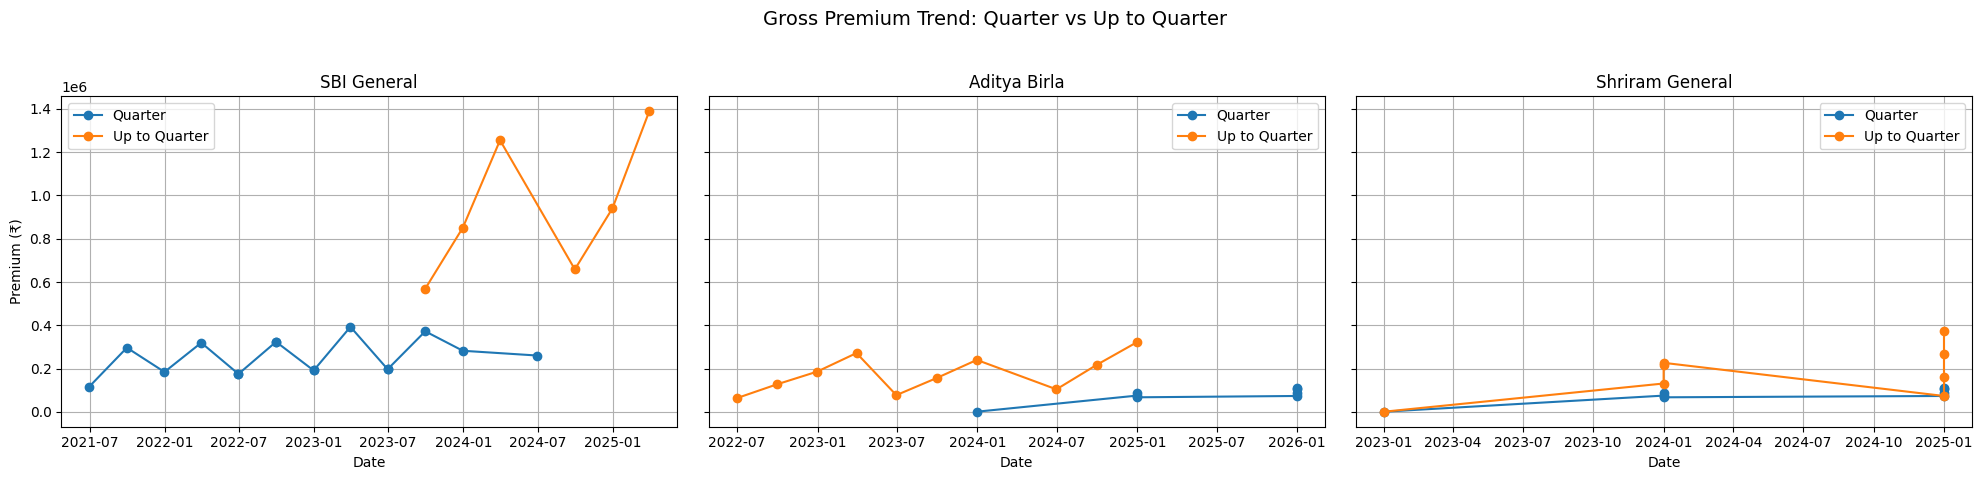

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

companies = [
    ("SBI General", SBI_quarter_df, SBI_upto_df),
    ("Aditya Birla", ABHI_quarter_df, ABHI_upto_df),
    ("Shriram General", SGI_quarter_df, SGI_upto_df)
]

for i, (company, df_quarter, df_upto) in enumerate(companies):
    axs[i].plot(pd.to_datetime(df_quarter["Date"]), df_quarter["Gross Premium"],
                marker='o', label="Quarter", color='tab:blue')
    axs[i].plot(pd.to_datetime(df_upto["Date"]), df_upto["Gross Premium"],
                marker='o', label="Up to Quarter", color='tab:orange')

    axs[i].set_title(company)
    axs[i].set_xlabel("Date")
    axs[i].grid(True)
    axs[i].legend()

axs[0].set_ylabel("Premium (₹)")
plt.suptitle("Gross Premium Trend: Quarter vs Up to Quarter", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


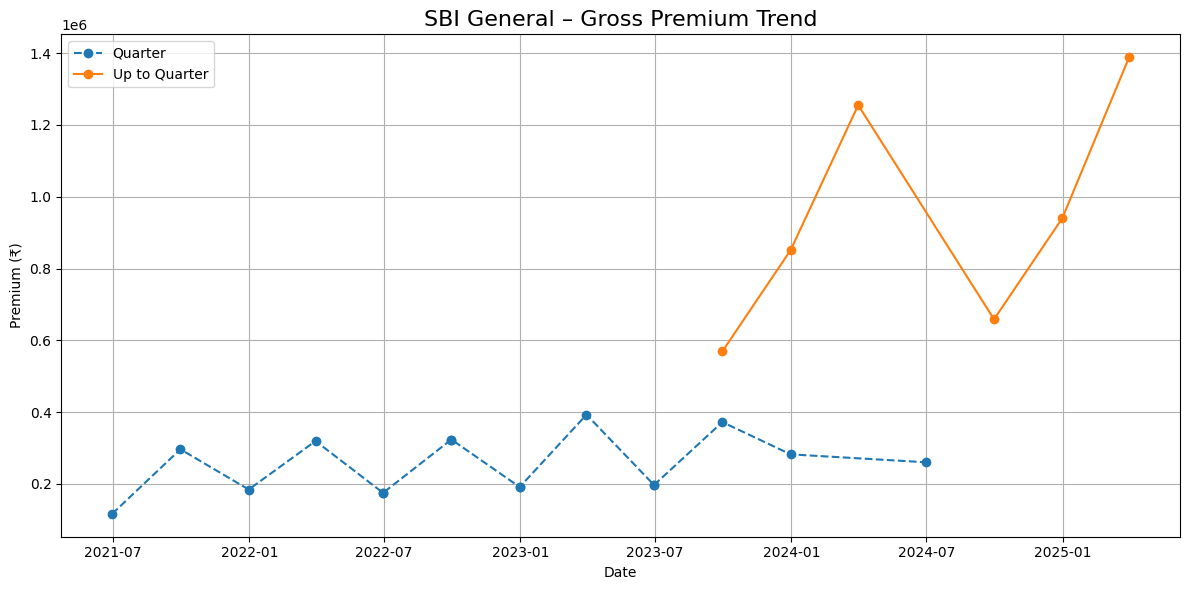

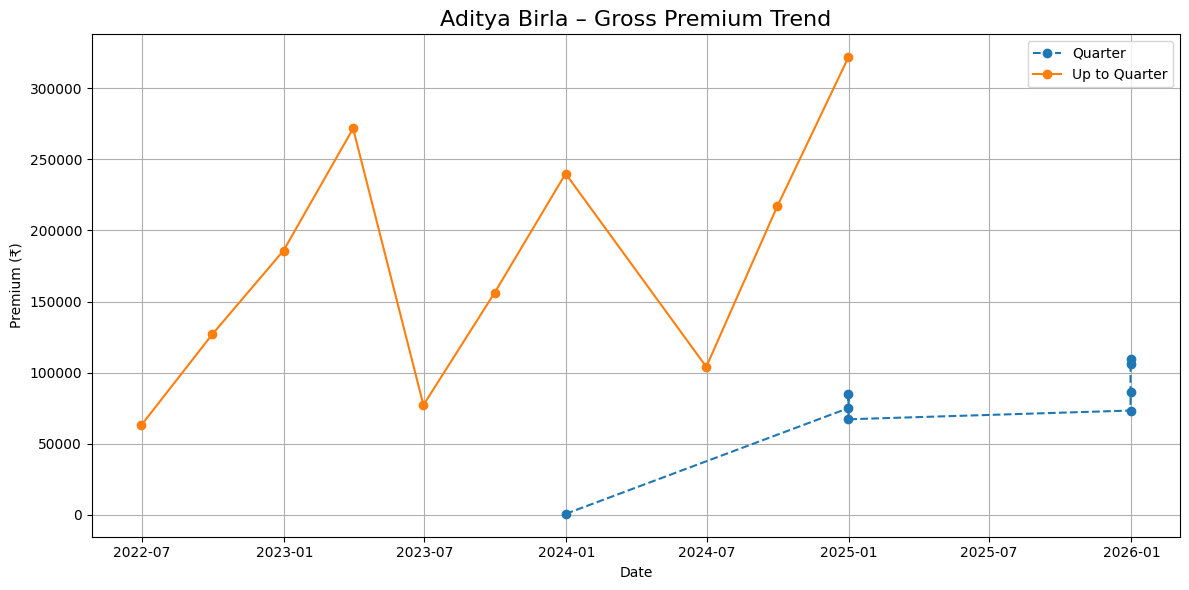

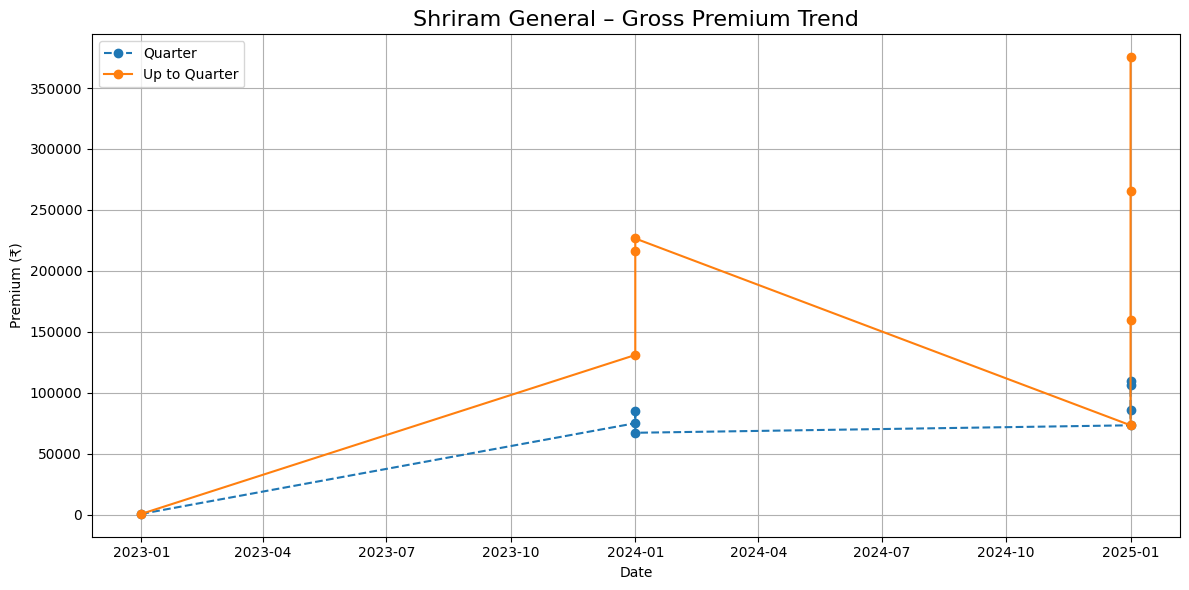

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

companies = [
    ("SBI General", SBI_quarter_df, SBI_upto_df),
    ("Aditya Birla", ABHI_quarter_df, ABHI_upto_df),
    ("Shriram General", SGI_quarter_df, SGI_upto_df)
]

for company, df_quarter, df_upto in companies:
    plt.figure(figsize=(12, 6))

    # Plot quarterly data
    plt.plot(pd.to_datetime(df_quarter["Date"]), df_quarter["Gross Premium"],
             marker='o', linestyle='--', color='tab:blue', label="Quarter")

    # Plot up-to data
    plt.plot(pd.to_datetime(df_upto["Date"]), df_upto["Gross Premium"],
             marker='o', linestyle='-', color='tab:orange', label="Up to Quarter")

    # Formatting
    plt.title(f"{company} – Gross Premium Trend", fontsize=16)
    plt.xlabel("Date")
    plt.ylabel("Premium (₹)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
